# Imports

In [236]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm

# Load Data

In [15]:
# Risk Free Rate
rf_rate = pd.read_csv('data/rf_data.csv')

In [50]:
# Models
log_reg_results = pd.read_pickle('models/log_reg_results.pkl')
rf_results = pd.read_pickle('models/rf_results.pkl')
svm_results = pd.read_pickle('models/svm_results.pkl')
xgb_results = pd.read_pickle('models/xgb_results.pkl')

In [31]:
# S&P 500 data
sp500_data = pd.read_csv('data/s&p500_data.csv')
sp500_data.set_index('Date', inplace=True)
sp500_data['Daily Returns'] = sp500_data['Close'].pct_change()

In [157]:
indicators = pd.read_csv('data/indicators.csv', index_col=0, parse_dates=True).loc['1997-01-01':]
indicators_w_polyterns = pd.read_csv('data/indicators_w_polyterms.csv', index_col=0, parse_dates=True).loc['1997-01-01':]
Y_Matrix = pd.read_csv('data/Y_Matrix.csv', index_col=0, parse_dates=True)

In [123]:
log_reg_results['long 3 days'][0]

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0], dtype=int32)),
             error_score='raise',
             estimator=Pipeline(steps=[('log_reg',
                                        LogisticRegression(max_iter=1000))]),
             n_jobs=-1,
             param_grid=[{'log_reg__C': [0.01, 0.1, 1, 10, 100],
                          'log_reg__class_weight': ['balanced', None],
                          'log_reg__penalty': ['l1', 'l2'],
                          'log_reg__solver': ['liblinear']},
                         {'log_reg__C': [0...
                          'log_reg__class_weight': ['balanced', None],
                          'log_reg__l1_ratio': [0.1, 0.5, 0.9],
                          'log_reg__penalty': ['elasticnet'],
                          'log_reg__solver': ['saga']}],
             refit='balanced_accuracy',
             scoring={'auc': make_scorer(roc_auc_score, response_method='predict_proba', multi_class=ovr),
                      'balanced_accuracy': 'balanced_accuracy',
                      'f1_macro': 'f1_macro', 'precision': 'precision_macro',
                      'recall': 'recall_macro'})

In [110]:
prova = dict(log_reg_results['long 3 days'][0].best_params_)

In [119]:
prova

{'log_reg__C': 0.01,
 'log_reg__class_weight': 'balanced',
 'log_reg__penalty': 'l2',
 'log_reg__solver': 'liblinear'}

In [132]:
prova_dict = {f'{key[9:]}':f'{value}' for key, value in prova.items()}

In [260]:
log_reg_results['long 3 days'][0].predict_proba(indicators)

array([[0.44384064, 0.55615936],
       [0.51809723, 0.48190277],
       [0.51308665, 0.48691335],
       ...,
       [0.50246197, 0.49753803],
       [0.44277595, 0.55722405],
       [0.39562095, 0.60437905]])

In [133]:
prova_model = LogisticRegression(**prova_dict)

In [257]:
prova_model.predict_proba(indicators)

NotFittedError: This LogisticRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

# Apply Models

In [265]:
def fit_models(indicators, params):
    final = []
    for type, tenure in tqdm(params.items()):
        per_strategy = []
        for i in range(len(tenure)):
            model = tenure[i]
            current_year = str(2000 + i)
            current_indicators = indicators.loc[current_year]
            probabilities = model.predict_proba(current_indicators)
            per_strategy.append(
                pd.DataFrame(probabilities[: , 1], index=current_indicators.index, columns=[f'{type}'])
            )
        final.append(pd.concat(per_strategy, axis=0))

    return pd.concat(final, axis=1)

In [266]:
prob_log_reg = fit_models(indicators, log_reg_results)
prob_rf = fit_models(indicators, rf_results)
prob_xgb = fit_models(indicators, xgb_results)
prob_svm = fit_models(indicators, svm_results)


100%|██████████| 8/8 [00:00<00:00, 14.97it/s]


# Rescale Position from Probabilities

In [63]:
# Set seed for reproducibility
np.random.seed(42)

# Generate random probabilities
position = pd.DataFrame({
    'long': np.random.rand(1000),
    'short': np.random.rand(1000)
})

In [295]:
def compute_position(probabilities):
    position =  probabilities.applymap(lambda x: (1/(1+np.exp(-20*(x-0.75))) - 1/(1+np.exp(5))) / (1/(1+np.exp(-5)) - 1/(1+np.exp(5))) if x >= 0.5 else 0)
    return position.shift(1)


In [296]:
position_log_reg = compute_position(prob_log_reg)
position_rf = compute_position(prob_rf)
position_xgb = compute_position(prob_xgb)
position_svm = compute_position(prob_svm)

In [297]:
position_log_reg

,long 3 days,short 3 days,long 5 days,short 5 days,long 8 days,short 8 days,long 10 days,short 10 days
Date,,,,,,,,
2000-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,0.003795,0.0,0.008288,0.0,0.159863,0.0,0.102669,0.000000
2000-01-05,0.407429,0.0,0.970293,0.0,0.990689,0.0,0.980568,0.000000
2000-01-06,0.296899,0.0,0.929078,0.0,0.979510,0.0,0.957658,0.000000
2000-01-07,0.234109,0.0,0.859247,0.0,0.963199,0.0,0.926504,0.000000
...,...,...,...,...,...,...,...,...
2024-12-23,0.032969,0.0,0.006749,0.0,0.006823,0.0,0.000000,0.000242
2024-12-24,0.008950,0.0,0.001856,0.0,0.001164,0.0,0.000000,0.000902
2024-12-26,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000


# Backtest Strategy

In [47]:
def backtest_strategy(position, asset, rf_rate, tc=0.0005):
    """
    Backtests a strategy with periodic rebalancing and transaction costs.

    Parameters:
      position : DataFrame with index of rebalancing dates and columns 'long' and 'short'
      asset    : DataFrame with a column 'Daily Returns' indexed by date (daily data)
      rf_rate  : Series (or DataFrame column) of daily risk-free rate values indexed by date
      tc       : Transaction cost rate (e.g., 0.001 for 0.1% cost per traded unit from risk free asset to risky asset)

    Returns:
      DataFrame with daily strategy returns and cumulative returns.
    """
    returns = pd.DataFrame(index=asset.index)
    returns['Daily Returns Strategy'] = 0

    # Assume starting with a full cash position (no asset exposure)
    curr_long, curr_short = 0, 0

    for date in asset.index:
        # Check if today is a rebalancing day (i.e. we have a new target position)
        if date in position.index:
            # Get the new positions for today
            new_long  = position.loc[date, 'long']
            new_short = position.loc[date, 'short']

            # Calculate the turnover (absolute change in positions)
            # Note: if positions are weights then the cost is proportional to the change
            trade_turnover = abs(new_long - curr_long) + abs(new_short - curr_short)

            # Compute the cost incurred on rebalancing
            transaction_cost = tc * trade_turnover

            # Update the current positions
            curr_long, curr_short = new_long, new_short
        else:
            transaction_cost = 0  # No rebalancing = no transaction cost

        # Get today's asset return and risk-free rate
        daily_asset_return = asset.loc[date, 'Daily Returns']
        daily_rf_rate = rf_rate.loc[date]

        # Compute net exposure
        net_exposure = curr_long + curr_short

        # Calculate the daily return.
        # Here, the asset return is applied to the net exposure, and the remaining
        # portion (1 - net_exposure) earns the risk-free rate.
        daily_return = net_exposure * daily_asset_return + (1 - net_exposure) * daily_rf_rate/365

        # Subtract any transaction cost incurred today
        daily_return -= transaction_cost

        # Save the daily strategy return
        returns.loc[date, 'Daily Returns Strategy'] = daily_return

    # Compute cumulative returns over time
    returns['Cumulative Returns'] = (1 + returns['Daily Returns Strategy']).cumprod() - 1

    return returns

In [45]:
# For reproducibility
np.random.seed(42)

# 1. Simulate Daily Data
# Create a daily date range for 200 business days
dates = pd.date_range(start='2020-01-01', periods=200, freq='B')

# Simulate asset daily returns: mean ~0.0005, std ~0.01 (typical daily return & volatility)
asset_returns = np.random.normal(loc=0.0005, scale=0.01, size=len(dates))
asset = pd.DataFrame({'Daily Returns': asset_returns}, index=dates)

# Simulate a constant risk-free rate of 0.0001 per day
rf_rate = pd.Series(0.0001, index=dates)

# 2. Simulate Rebalancing Positions Data
# We rebalance every 3 days
rebalancing_dates = dates[::3]

# Generate positions:
# "long" weights between 0.4 and 0.6 and "short" weights between 0.0 and 0.2.
long_positions = np.random.uniform(0.4, 0.6, len(rebalancing_dates))
short_positions = np.random.uniform(0.0, 0.2, len(rebalancing_dates))

position = pd.DataFrame({
    'long': long_positions,
    'short': short_positions
}, index=rebalancing_dates)


            Daily Returns Strategy  Cumulative Returns
2020-01-01                0.003275            0.003275
2020-01-02               -0.000614            0.002659
2020-01-03                0.005100            0.007772
2020-01-06                0.008537            0.016375
2020-01-07               -0.000970            0.015389
2020-01-08               -0.000970            0.014405
2020-01-09                0.009181            0.023718
2020-01-10                0.004643            0.028471
2020-01-13               -0.002316            0.026089
2020-01-14                0.003287            0.029461


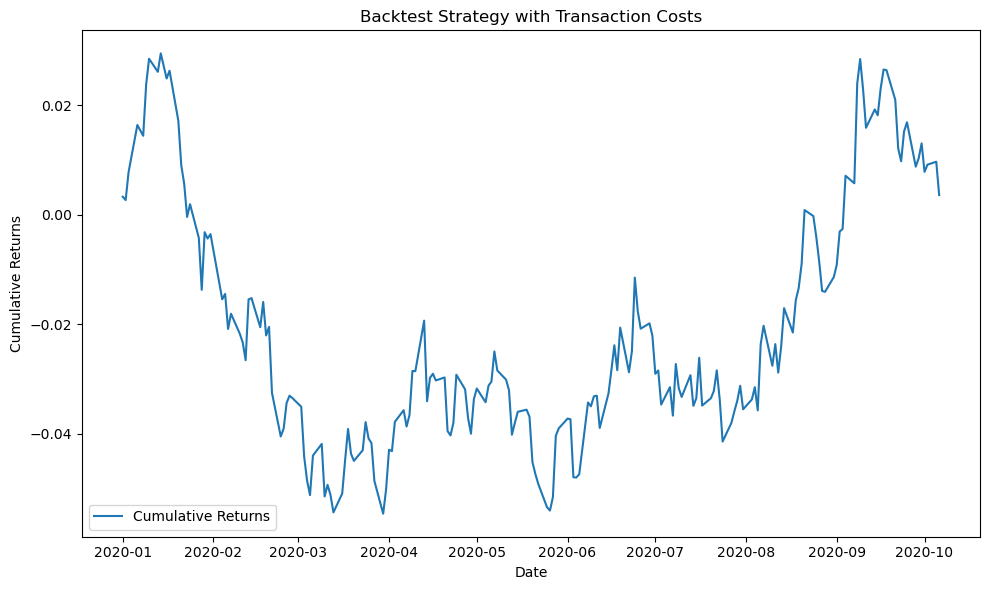

In [48]:
results = backtest_strategy(position, asset, rf_rate, tc=0.001)

# Display the first few rows of the results
print(results.head(10))

# Plot the cumulative returns over time
plt.figure(figsize=(10, 6))
plt.plot(results.index, results['Cumulative Returns'], label='Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Backtest Strategy with Transaction Costs')
plt.legend()
plt.tight_layout()
plt.show()

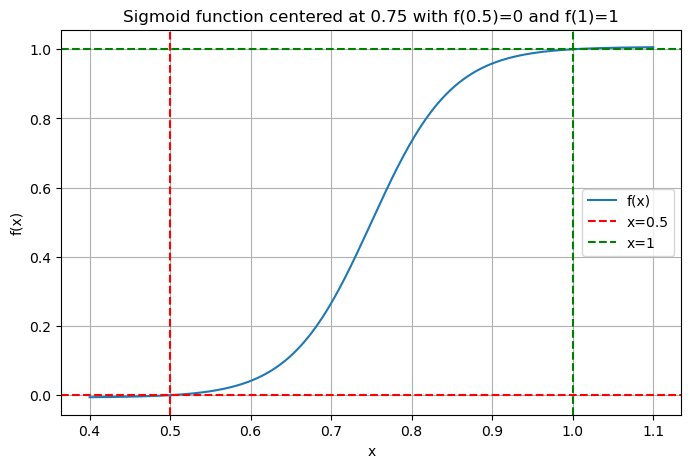

In [278]:
import numpy as np
import matplotlib.pyplot as plt

# Define the function
def f(x):
    return (1/(1+np.exp(-20*(x-0.75))) - 1/(1+np.exp(5))) / (1/(1+np.exp(-5)) - 1/(1+np.exp(5)))

# Generate x values
x_vals = np.linspace(0.4, 1.1, 500)
y_vals = f(x_vals)

# Create the plot
plt.figure(figsize=(8,5))
plt.plot(x_vals, y_vals, label='f(x)')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Sigmoid function centered at 0.75 with f(0.5)=0 and f(1)=1')
plt.axvline(x=0.5, color='red', linestyle='--', label='x=0.5')
plt.axvline(x=1.0, color='green', linestyle='--', label='x=1')
plt.axhline(y=0, color='red', linestyle='--')
plt.axhline(y=1, color='green', linestyle='--')
plt.legend()
plt.grid(True)
plt.show()